In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import rasterio

import os

from matplotlib import rcParams

In [14]:
from nickyspatial import (
    LayerManager,
    SlicSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_layer,
    read_raster,
)

In [2]:
path = "/Users/devseed/Documents/repos/OBIA_workflow/data/Sentinel2A_subset_bands_ToA_BGRNirSWIR1SWIR2.tif"

In [15]:
image_data, transform, crs = read_raster(path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (6, 1288, 1320)
Coordinate system: EPSG:32633


In [16]:
manager = LayerManager()

segmenter = SlicSegmentation(scale=40, compactness=1)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 1062
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 1056)


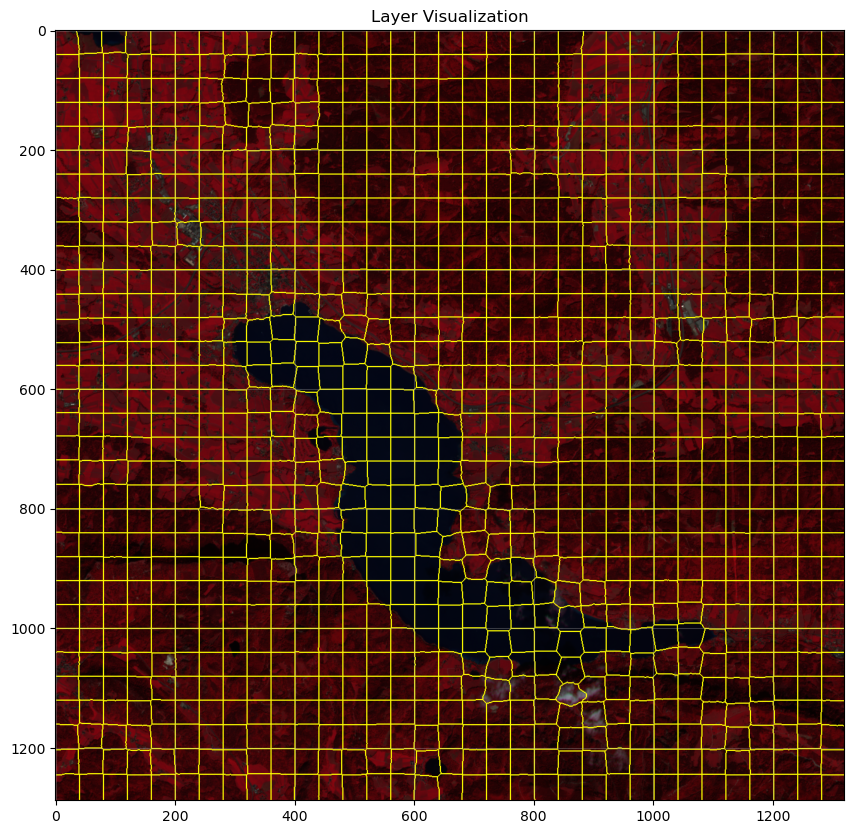

In [20]:
fig1 = plot_layer(segmentation_layer, image_data, rgb_bands=(3, 2, 1), show_boundaries=True)
plt.show()


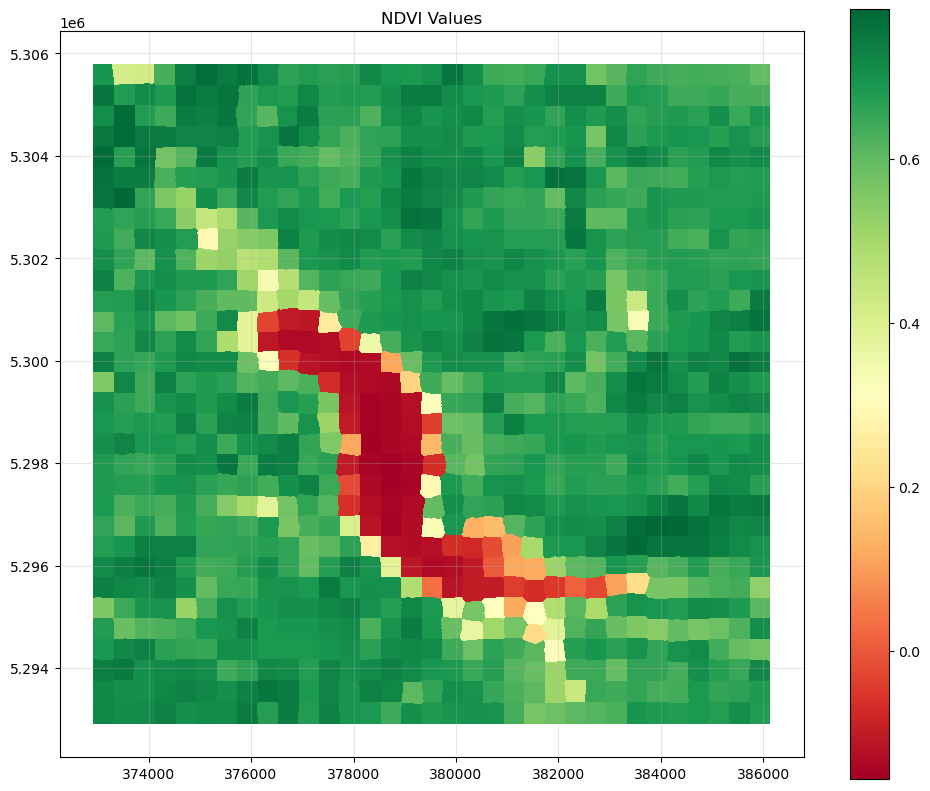

In [22]:
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)

segmentation_layer.attach_function(
    attach_spectral_indices,
    name="spectral_indices",
    bands={
        "blue": "band_1_mean",
        "green": "band_2_mean",
        "red": "band_3_mean",
        "nir": "band_4_mean",
    },
)

fig2 = plot_layer(segmentation_layer, attribute="NDVI", title="NDVI Values", cmap="RdYlGn")
plt.show()


In [25]:
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")


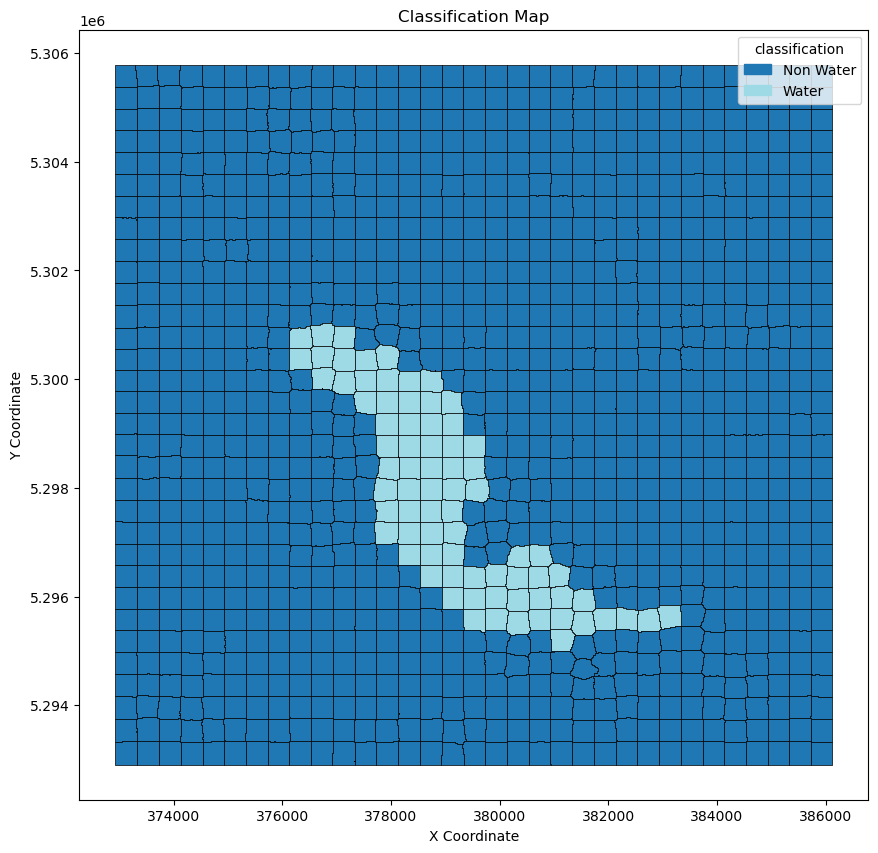

In [27]:
land_cover_rules = RuleSet(name="Land_Cover")
land_cover_rules.add_rule(name="Non Water", condition="NDVI > 0.2")
land_cover_rules.add_rule(name="Water", condition="NDVI <= 0.2")

land_cover_layer = land_cover_rules.execute(
    segmentation_layer,
    layer_manager=manager,
    layer_name="Land_Cover",
)

fig3 = plot_classification(land_cover_layer, class_field="classification")
plt.show()
